In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.append('/nfs/team283/aa16/VeloVAE/')
import velovae as vv
import pickle as pickle
from eval_utils import cross_boundary_correctness
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
datasets = ['Pancreas_with_cc', 'DentateGyrus' , 'MouseBoneMarrow', 'MouseErythroid', 'Hindbrain_pons', 'HumanBoneMarrow',
            'RetinaDevelopment', 'Pancreas_without_cc', 'IntestinalOrganoids', 'scNT_seq']
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'

Pancreas_with_cc
Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Initialization using the steady-state and dynamical models.
Gaussian Prior.
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stag

Epoch 400: Train ELBO = 1757.869, Test ELBO = 1719.056, 	 Total Time =   0 h :  1 m : 22 s
Epoch 500: Train ELBO = 1786.305, Test ELBO = 1759.139, 	 Total Time =   0 h :  1 m : 42 s
Epoch 600: Train ELBO = 1825.537, Test ELBO = 1790.569, 	 Total Time =   0 h :  2 m :  3 s
*********       Stage 1: Early Stop Triggered at epoch 676.       *********
*********                      Stage  2                       *********
Cell-wise KNN Estimation.
Percentage of Invalid Sets: 0.028
Average Set Size: 65
Finished. Actual Time:   0 h :  0 m :  1 s
Epoch 677: Train ELBO = 1787.301, Test ELBO = 1761.784, 	 Total Time =   0 h :  2 m : 20 s
Epoch 700: Train ELBO = 1816.853, Test ELBO = 1783.715, 	 Total Time =   0 h :  2 m : 25 s
*********       Stage 2: Early Stop Triggered at epoch 705.       *********
*********              Finished. Total Time =   0 h :  2 m : 26 s             *********
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacenc

Epoch 1: Train ELBO = -19505.592, Test ELBO = -81581.250, 	 Total Time =   0 h :  0 m :  0 s
Epoch 100: Train ELBO = 2400.258, Test ELBO = 2394.793, 	 Total Time =   0 h :  0 m : 45 s
Epoch 200: Train ELBO = 3029.893, Test ELBO = 2995.070, 	 Total Time =   0 h :  1 m : 29 s
Epoch 300: Train ELBO = 3228.467, Test ELBO = 3187.365, 	 Total Time =   0 h :  2 m : 14 s
Epoch 400: Train ELBO = 3292.229, Test ELBO = 3253.691, 	 Total Time =   0 h :  2 m : 58 s
*********       Stage 1: Early Stop Triggered at epoch 433.       *********
*********                      Stage  2                       *********
Cell-wise KNN Estimation.
Percentage of Invalid Sets: 0.081
Average Set Size: 246
Finished. Actual Time:   0 h :  0 m :  3 s
Epoch 434: Train ELBO = 257.005, Test ELBO = -726.656, 	 Total Time =   0 h :  3 m : 17 s
*********       Stage 2: Early Stop Triggered at epoch 497.       *********
*********              Finished. Total Time =   0 h :  3 m : 48 s             *********
computing neighb

    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Initialization using the steady-state and dynamical models.
Gaussian Prior.
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -36479.238, Test ELBO = -91386.844, 	 Total Time =   0 h :  0 m :  1 s
Epoch 100: Train ELBO = 2504.275, Test ELBO = 2401.686, 	 Total Time =   0 h :  0 m : 30 s
Epoch 200: Train ELBO = 2985.127, Test ELBO = 2931.531, 	 Total Time =   0

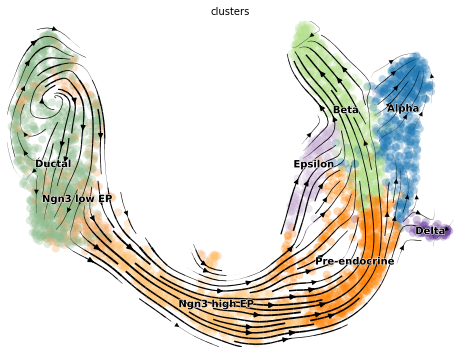

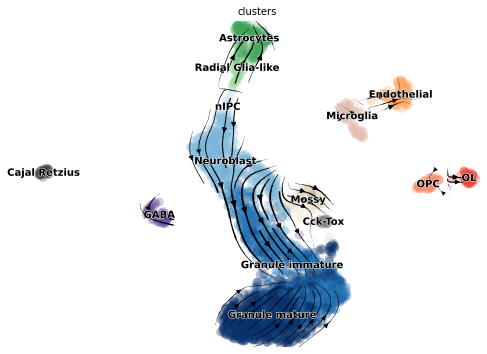

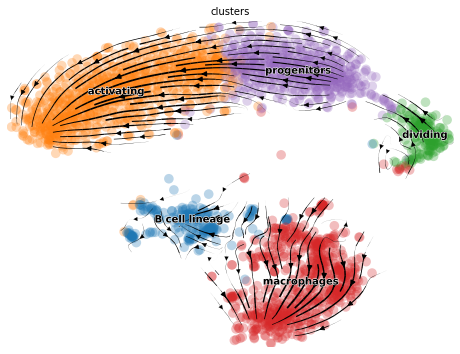

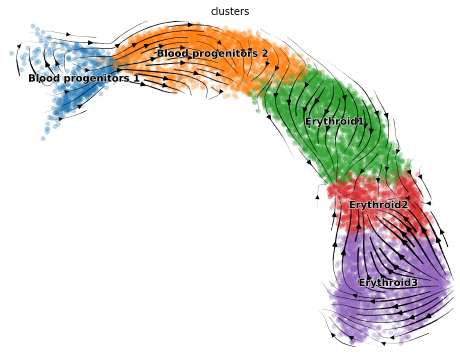

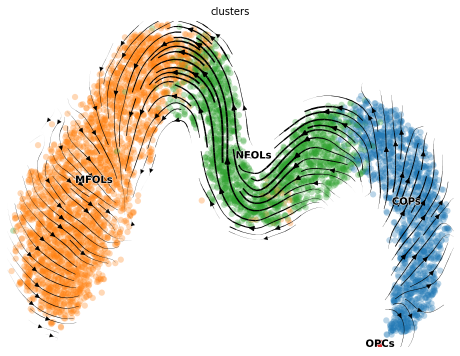

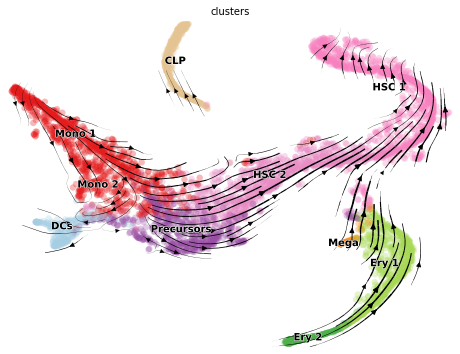

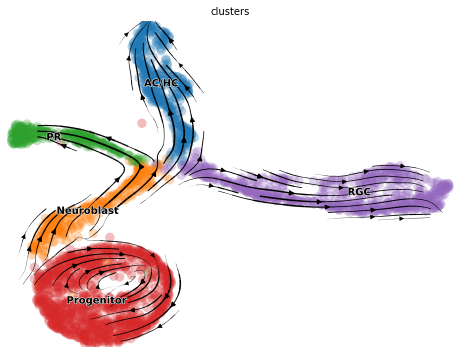

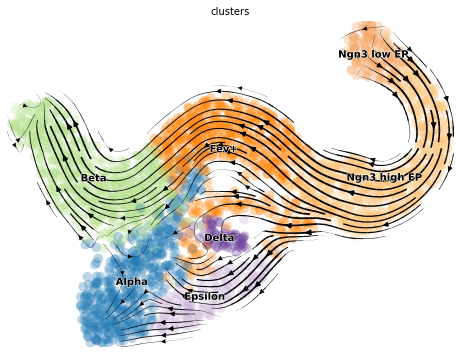

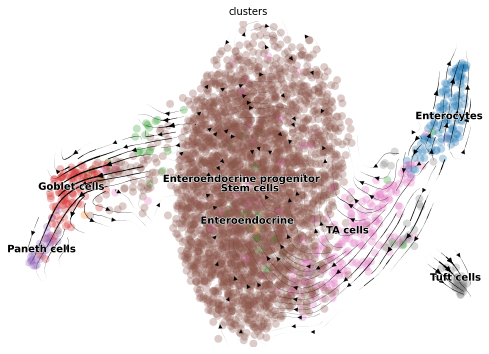

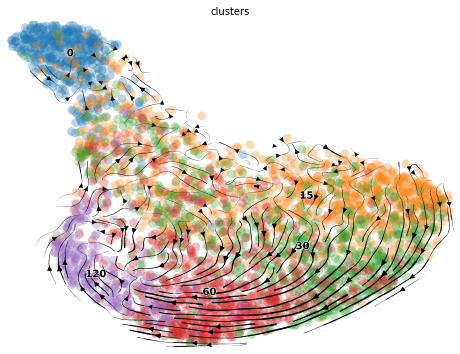

In [3]:
for dataset in datasets:
    print(dataset)
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    torch.manual_seed(2022)
    np.random.seed(2022)
    full_vb = vv.VAEFullVB(adata, tmax=20, dim_z=5, device='cuda:0')
    full_vb.train(adata, plot=True, embed="umap")
    scv.pp.neighbors(adata)
    scv.tl.velocity_graph(adata, vkey = 'velocity')
    scv.tl.velocity_embedding(adata, vkey = 'velocity')
    fix, ax = plt.subplots(1, 1, figsize = (8, 6))
    scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                     show = False, ax = ax)
    plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_VeloVAE1.png')
    # Calculate performance:
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    mean_score = cross_boundary_correctness(adata = adata, k_cluster = 'clusters',
                               k_velocity = 'velocity', cluster_edges = ground_truth)
    print(mean_score)
    tab = pd.read_csv(save_dir + dataset + '_scores.csv', index_col = 0)
    tab.loc['veloVAE1',:] = np.array(list(mean_score[0].values()) + [mean_score[1]])
    tab.to_csv(save_dir + dataset + '_scores.csv')   